# Computing and parsing phylogenetic trees
(Víctor Sojo | vsojo@amnh.org)

In the previous lesson we installed and used MAFFT to align multiple sequences of the 12S rRNA gene for several mammals. Here we will use that alignment to compute a phylogenetic tree using FastTree.

We will then parse this tree using ETE3, a mighty tool for analysing phylogenetic trees.

Both of these tools are available through `conda`, so we will install and load them from there.

**References**<br/>
+ The help for FastTree.
+ The [ETE manual](http://etetoolkit.org/).

## Contents
&emsp;[Installing required software via conda](#Installing-required-software-via-conda)<br/>
&emsp;[Importing required modules](#Importing-required-modules)<br/>
&emsp;[Exploring the alignment file](#Exploring-the-alignment-file)<br/>
&emsp;[Computing a phylogenetic tree with FastTree](#Computing-a-phylogenetic-tree-with-FastTree)<br/>
&emsp;[Using ETE to parse and manipulate phylogenetic trees](#Using-ETE-to-parse-and-manipulate-phylogenetic-trees)<br/>
&emsp;&emsp;[Loading a tree into ete3](#Loading-a-tree-into-ete3)<br/>
&emsp;&emsp;[Exploring the tree's leaves](#Exploring-the-tree's-leaves)<br/>
&emsp;&emsp;[Exploring a tree's children \(i.e. the nodes under a parent node\)](#Exploring-a-tree's-children-\(i.e.-the-nodes-under-a-parent-node\))<br/>
&emsp;&emsp;[Getting the common ancestor of a group of taxa](#Getting-the-common-ancestor-of-a-group-of-taxa)<br/>
&emsp;&emsp;[Rooting or re-rooting a tree](#Rooting-or-re-rooting-a-tree)<br/>
&emsp;&emsp;[Selecting a branch by name using &](#Selecting-a-branch-by-name-using-&)<br/>
&emsp;&emsp;[Distances between nodes](#Distances-between-nodes)<br/>
&emsp;&emsp;[Naming internal nodes](#Naming-internal-nodes)<br/>
&emsp;&emsp;[Annotating a tree](#Annotating-a-tree)<br/>
&emsp;&emsp;[Making a copy of a tree](#Making-a-copy-of-a-tree)<br/>
&emsp;&emsp;[Deleting \(detaching\) leaves in a tree](#Deleting-\(detaching\)-leaves-in-a-tree)<br/>
&emsp;&emsp;[Pruning a tree](#Pruning-a-tree)<br/>
&emsp;&emsp;[Saving a tree to a Newick file](#Saving-a-tree-to-a-Newick-file)<br/>
&emsp;&emsp;[Checking for monophyly](#Checking-for-monophyly)<br/>
&emsp;&emsp;[Comparing trees](#Comparing-trees)<br/>
&emsp;&emsp;[Creating and exporting tree images with ete3](#Creating-and-exporting-tree-images-with-ete3)<br/>
&emsp;&emsp;[Exporting a tree image to a file](#Exporting-a-tree-image-to-a-file)<br/>
&emsp;&emsp;[Colouring branches to match taxonomy](#Colouring-branches-to-match-taxonomy)<br/>
&emsp;&emsp;[Advanced ETE tree styling](#Advanced-ETE-tree-styling)<br/>

Once again, let's make sure that we're using the `bioinfo` environment that we created in the `Py201` notebook:

In [1]:
!echo $CONDA_DEFAULT_ENV

bioinfo


(If you're on Windows, remember that every line with `!my code` should be changed to `!wsl my code` and you should have an active [WSL installation](https://docs.microsoft.com/en-us/windows/wsl/install-win10))

## Installing required software via `conda`
We have aligned sequences from the previous lesson. Here we want to align them. There are multiple packages to produce phylogenetic trees. Two very popular ones are `iqtree` and `fasttree`. Both of these are maximum-likelihood applications, and both are on `conda` (as long as you have the `bioconda` channel, which we added on an earlier lesson).

FastTree does what it says on the tin, and it is great for exploration or when you need to produce hundreds or thousands of trees quickly. For more reliability, you may want to use IQ-Tree instead, which by default performs a very thorough exploration of a vast array of maximum-likelihood models, performs statistical tests on them, and then gives out the best (most likely) one. Here, however, we will use `fasttree`, merely because it's quicker.

Once we have a tree, we will want to parse it. For that, we will use the Python Environment for Tree Exploration (better known as ETE) version 3.

Let's have conda download and install both `fasttree` and `ete3`:

In [2]:
!conda install -y fasttree ete3

Solving environment: done

# All requested packages already installed.



I already have them both, so it's only a few seconds while `conda` checks for updates. It may take a couple of minutes in your case if you don't have them installed or need to update.

## Importing required modules
Here we will need:

Module             | Use
:------------------|:-----------------------------------------
**ete3.Tree**      | To read, parse, draw, and manipulate phylogenetic trees
**ete3.TreeStyle** | To manipulate the visual style and overall tree looks
**ete3.NodeStyle** | To manipulate the visual style of specific tree nodes

We will also use the `fasttree` package of `conda`, but this is not a Python module and so we don't need to import it.

In [3]:
from ete3 import Tree, TreeStyle, NodeStyle

## Exploring the alignment file
We have an alignment from the previous lesson, let's take a look:

In [4]:
aligned_file = "Mammals_12S_rRNA.mafft.fasta"
!grep -A2 "^>" $aligned_file # -A2 means "show me the line I look for, and the two following ones"

>Human Homo_sapiens MK617223.1
aataggtttggtcctagcctttctattagctcttagtaagattacacatgcaagcatccc
cgttccagtgagt-tcaccctctaaatca-ccac---gatcaaaaggaacaagcatcaag
--
>GiantPanda Ailuropoda_melanoleuca KP306769.1
taaaggtttggtcctagccttcctattagccattaacaagattacacatgtaagtctcca
cgctccagtgaaa-atgccccttaagtcctcttagacgacctaaaggagcgggtatcaag
--
>RedPanda Ailurus_fulgens Y08511.1
caaaggtttggtcctagccttcccgttagttcttaataaaattacacatgcaagtatcta
caccccagtgaaa-atgccctccaaatca-ctag-ttgattaaaaggagcaggtatcaag
--
>Koala Phascolarctos_cinereus U61076.1
taaaggtttgatcctagccttactgttagttttaattaaacttacacatgcaagtttccg
caacccagtgaga-atgccc-ccaaaatttatacacaatttagcaggagcagacatcagg
--
>CommonOpossum Didelphis_marsupialis AJ628374.1
----------------gccttgttattagttctaattagacctacacatgcaagtttccg
ctatccagtgaga-atgccc-ttaagtc-------ttaagcaaaaggagctggtatcagg
--
>VirginiaOpossum Didelphis_virginiana Z29573.1
-ataggtttggtcctagccttattattagttctaattagacctacacatgcaagtttccg
ctacccagtgaga-atgccctttaagtcttataaattaagcaaaaggagctggtatcagg
--
>Bro

Let's count the number of sequences:

In [5]:
!grep -c "^>" $aligned_file

23


We have `23` sequences, and as you can tell from the occassional dashes within the sequences, these sequences are aligned.

Don't be confused with the `--` that separates each result. These are inserted by `grep` to make its output easier to read.

## Computing a phylogenetic tree with FastTree
Let's start by creating a file name based on the name of the alignment file:

In [6]:
# Change the name so that we replace the extension with an appropriate one (.nwk for NEWICK),
# plus an identifier to the software we used (FastTree)
tree_file = aligned_file.replace(".fasta", ".FastTree.nwk")

Now, let's compute the tree using `fasttree`. We use the `-nt` flag to let FastTree know that we're providing nucleotide sequences:

In [7]:
!fasttree -nt $aligned_file > $tree_file

FastTree Version 2.1.10 Double precision (No SSE3)
Alignment: Mammals_12S_rRNA.mafft.fasta
Nucleotide distances: Jukes-Cantor Joins: balanced Support: SH-like 1000
Search: Normal +NNI +SPR (2 rounds range 10) +ML-NNI opt-each=1
TopHits: 1.00*sqrtN close=default refresh=0.80
ML Model: Jukes-Cantor, CAT approximation with 20 rate categories
Initial topology in 0.00 seconds
Refining topology: 18 rounds ME-NNIs, 2 rounds ME-SPRs, 9 rounds ML-NNIs
Total branch-length 1.654 after 0.08 sec
ML-NNI round 1: LogLk = -9789.343 NNIs 2 max delta 9.36 Time 0.13
Switched to using 20 rate categories (CAT approximation)1 of 20   
Rate categories were divided by 0.844 so that average rate = 1.0
CAT-based log-likelihoods may not be comparable across runs
Use -gamma for approximate but comparable Gamma(20) log-likelihoods
ML-NNI round 2: LogLk = -8714.027 NNIs 0 max delta 0.00 Time 0.15
Turning off heuristics for final round of ML NNIs (converged)
ML-NNI round 3: LogLk = -8713.451 NNIs 0 max delta 0.00 Ti

FastTree just made a file in the NEWICK format. We can try to take a look at it:

In [8]:
!cat $tree_file

((GiantPanda:0.067464181,(BlackBear:0.024764211,(BrownBear:0.003779600,PolarBear:0.005713061)0.984:0.022844150)1.000:0.056106382)0.999:0.052632732,(((Coyote:0.010373214,Wolf:0.006904605)0.999:0.037880561,(RedFox:0.013200608,ArcticFox:0.016384950)0.991:0.023787816)1.000:0.043850513,(RedPanda:0.087920611,(Raccoon:0.070781662,(EurasianRiverOtter:0.031069123,SeaOtter:0.037027741)1.000:0.048696933)0.695:0.021960260)0.904:0.025463097)0.713:0.014324875,((Jaguar:0.030226034,DomesticCat:0.042128688)1.000:0.064367668,((Pig:0.076032116,(Cow:0.117595292,BlueWhale:0.099244577)0.405:0.023961284)0.982:0.038848577,((Human:0.160504899,NthAmBeaver:0.129195814)0.859:0.041582066,((Koala:0.157312722,(CommonOpossum:0.015853953,VirginiaOpossum:0.016222124)1.000:0.079513024)1.000:0.087135966,HouseMouse:0.163735649)0.864:0.019566281)0.790:0.023475613)0.950:0.021917707)0.907:0.022186608);


...but as you can see, that's not particularly easy to interpret. To visualise this file, we can open it in a tree-viewing software such as [FigTree](http://tree.bio.ed.ac.uk/software/figtree/) (which unfortunately was last updated in Nov. 2020 and does not work well with macOS Big Sur) or upload it to [iTOL](https://itol.embl.de/upload.cgi) and see it on their website.

Here's what I see on FigTree:
![Screenshot of a tree of mammalian 12S rRNA sequences in FigTree](https://raw.githubusercontent.com/vsojo/Python_Workshop/DataAnalysis/Mammals_12S_rRNA.mafft.FastTree.nwk.jpg "FastTree ML Tree of MAFFT alignment of DNA sequences encoding 12S rRNA from 23 mammals.")

This looks great... other than the fact that beavers (which are rodents) ended up being more related to humans than to house mice (another rodent)...

Other than that weirdness with the mice refusing to join the beavers, some other valid interesting relationships do appear: the three marsupials are neatly together, the carnivores form a big joint clade, and the whale groups with the cow and pig.

Something else worth noting: giant pandas and red pandas don't seem to be as closely related as their names would suggest. Instead, giant pandas are very close to bears, whereas the red panda clusters with the musteloids (raccoons, otters and so on). This matches what is commonly accepted in the literature at present.

Why we got that weird mouse/beaver/human result is an interesting question that we won't solve here. Maybe we need more primate and rodent sequences; maybe just using the 12S rRNA gene does not give enough information to tell these lineages apart; maybe FastTree was too _fast_ for its own good; maybe there was something wrong with the default parameters we used for the alignment; or maybe we just picked the wrong evolutionary model.

This is not a workshop on phylogeny, but I just wanted to show that:

⚠️ **Just because you build a phylogenetic tree, it doesn't mean you'll get the _correct_ relationships. All trees (and multiple-sequence alignments) are hypotheses, and as such they can be right or they can be wrong.** ⚠️

## Using ETE to parse and manipulate phylogenetic trees
ETE is a great tool for processing, printing, analysing, and manipulating phylogenetic trees. We will only take a very superficial look at it. You are strongly encouraged to delve deep into its mighty powers on [their website](http://etetoolkit.org).

### Loading a tree into ete3
Let's start by loading the tree that we made above (whose file name is still stored in the variable `tree_file`:

In [9]:
fstree = Tree(tree_file)

(you can of course name your tree anything you want; I named it `fstree` because we made it with FastTree, but many people just call their trees `t`)

Typically a good idea to just print something to see what it holds:

In [10]:
print(fstree)


      /-GiantPanda
   /-|
  |  |   /-BlackBear
  |   \-|
  |     |   /-BrownBear
  |      \-|
  |         \-PolarBear
  |
  |         /-Coyote
  |      /-|
  |     |   \-Wolf
  |   /-|
  |  |  |   /-RedFox
  |  |   \-|
  |--|      \-ArcticFox
--|  |
  |  |   /-RedPanda
  |   \-|
  |     |   /-Raccoon
  |      \-|
  |        |   /-EurasianRiverOtter
  |         \-|
  |            \-SeaOtter
  |
  |      /-Jaguar
  |   /-|
  |  |   \-DomesticCat
  |  |
  |  |      /-Pig
   \-|   /-|
     |  |  |   /-Cow
     |  |   \-|
     |  |      \-BlueWhale
      \-|
        |      /-Human
        |   /-|
        |  |   \-NthAmBeaver
        |  |
         \-|      /-Koala
           |   /-|
           |  |  |   /-CommonOpossum
            \-|   \-|
              |      \-VirginiaOpossum
              |
               \-HouseMouse


Nice! ete3 prints the topology of the tree as an ASCII text. This can be very helpful on its own.

You may think that this is not the same tree we saw on FigTree. It is; the difference is that in the image above I had re-rooted the tree around the marsupials (which I assumed should be an outgroup to all the other mammals that we have here. We can root and re-root trees with ete3 as well, and we will do so later in this lesson.

But for now, let's explore our tree a bit.

### Exploring the tree's leaves
Following the analogy of a tree, the convention is to call the tips of a tree, i.e. the taxa, "leaves". We can easily explore these in ete3:

In [11]:
for leaf in fstree:
    print(leaf.name)

GiantPanda
BlackBear
BrownBear
PolarBear
Coyote
Wolf
RedFox
ArcticFox
RedPanda
Raccoon
EurasianRiverOtter
SeaOtter
Jaguar
DomesticCat
Pig
Cow
BlueWhale
Human
NthAmBeaver
Koala
CommonOpossum
VirginiaOpossum
HouseMouse


### Exploring a tree's children (i.e. the nodes under a parent node)
We can also explore the separate sub-trees of the tree, which in node jargon are called "children":

In [12]:
print(fstree.children[0])


   /-GiantPanda
--|
  |   /-BlackBear
   \-|
     |   /-BrownBear
      \-|
         \-PolarBear


If we try to print the whole of `children`, we get something not so easy to interpret:

In [13]:
print(fstree.children)

[Tree node '' (0x10bcc5eb), Tree node '' (0x1a303e04), Tree node '' (0x1a303e5e)]


Not too easy to make sense of, but it does hint at something important:

⚠️ ETE children are all the **nodes** in a tree, whether they be _outer/leaf/tip nodes_ (the taxa), or _internal nodes_ (everythinig else, i.e. all the ancestral nodes, such as that node between PolarBear & BrownBear, and the one between their ancestor and BlackBear, and then the one between the common ancestor of all bears and GiantPanda).


Instead of printing all of `children`, we can do a for loop:

In [14]:
for i, child in enumerate(fstree.children):
    print(f"\nChild #{i}:")
    print(child)


Child #0:

   /-GiantPanda
--|
  |   /-BlackBear
   \-|
     |   /-BrownBear
      \-|
         \-PolarBear

Child #1:

         /-Coyote
      /-|
     |   \-Wolf
   /-|
  |  |   /-RedFox
  |   \-|
--|      \-ArcticFox
  |
  |   /-RedPanda
   \-|
     |   /-Raccoon
      \-|
        |   /-EurasianRiverOtter
         \-|
            \-SeaOtter

Child #2:

      /-Jaguar
   /-|
  |   \-DomesticCat
  |
  |      /-Pig
--|   /-|
  |  |  |   /-Cow
  |  |   \-|
  |  |      \-BlueWhale
   \-|
     |      /-Human
     |   /-|
     |  |   \-NthAmBeaver
     |  |
      \-|      /-Koala
        |   /-|
        |  |  |   /-CommonOpossum
         \-|   \-|
           |      \-VirginiaOpossum
           |
            \-HouseMouse


Take a look again at the full tree, and you'll see that it indeed has three sub-trees.

We can get the children of the children of the children... for as many sub-levels as there are in the tree. For example, to get the **Marsupials**, we would first need child `2` of the original tree (the last one printed above). Of this sub-tree, child `0` has the two cats, and the other child (`1`) has everything else, so we pick `1`. Then, child `1` has the big group with Human, NthAmBeaver, HouseMouse, and the Marsupials. Child `1` of that has marsupials and mouse, of whom child `0` has the marsupials:

In [15]:
marsupial_ancestor = fstree.children[2].children[1].children[1].children[1].children[0]
print(marsupial_ancestor)


   /-Koala
--|
  |   /-CommonOpossum
   \-|
      \-VirginiaOpossum


Phew, that was a mouthful. Surely there must be a better way to get groups! There is, and we explore that next.

(You'll note that we can extract our selections to a variable, which in this case we conveniently named `marsupials`)

### Getting the common ancestor of a group of taxa

In [16]:
marsupial_ancestor = fstree.get_common_ancestor('Koala', 'CommonOpossum', 'VirginiaOpossum')
print(marsupial_ancestor)


   /-Koala
--|
  |   /-CommonOpossum
   \-|
      \-VirginiaOpossum


We get the same result as with the above method of inspecting the children visually, but this is of course much more reliable.

The problem arises when the taxa that (we think) should form a group don't. For example, you'll remember that our two rodents don't seem to have any inclination to stick together. Let's see what happens if we get their common ancestor:

In [17]:
rodent_ancestor = fstree.get_common_ancestor('HouseMouse', 'NthAmBeaver')
print(rodent_ancestor)


      /-Human
   /-|
  |   \-NthAmBeaver
  |
--|      /-Koala
  |   /-|
  |  |  |   /-CommonOpossum
   \-|   \-|
     |      \-VirginiaOpossum
     |
      \-HouseMouse


Disaster... our rodents seem to be a little confused, and there isn't much we can do about it.

### Rooting or re-rooting a tree
Let's see what the present root of the tree is:

In [18]:
print(fstree.get_tree_root())


      /-GiantPanda
   /-|
  |  |   /-BlackBear
  |   \-|
  |     |   /-BrownBear
  |      \-|
  |         \-PolarBear
  |
  |         /-Coyote
  |      /-|
  |     |   \-Wolf
  |   /-|
  |  |  |   /-RedFox
  |  |   \-|
  |--|      \-ArcticFox
--|  |
  |  |   /-RedPanda
  |   \-|
  |     |   /-Raccoon
  |      \-|
  |        |   /-EurasianRiverOtter
  |         \-|
  |            \-SeaOtter
  |
  |      /-Jaguar
  |   /-|
  |  |   \-DomesticCat
  |  |
  |  |      /-Pig
   \-|   /-|
     |  |  |   /-Cow
     |  |   \-|
     |  |      \-BlueWhale
      \-|
        |      /-Human
        |   /-|
        |  |   \-NthAmBeaver
        |  |
         \-|      /-Koala
           |   /-|
           |  |  |   /-CommonOpossum
            \-|   \-|
              |      \-VirginiaOpossum
              |
               \-HouseMouse


The root of the tree is the node that contains... well.. the whole tree. So we see no difference with printing the root versus printing the whole tree.

⚠️ The fact that we can see 3 nodes (branches) at the highest (leftmost) level typically indicates that this tree is actually _unrooted_.

We can define or redefine a tree's root to any node we wish. Here it would make evolutionary sense to root the tree at the marsupials, since they should be external to the placentals who evolved from marsupials quite a while back (somewhere between 66 and 90 Ma, if you care to know).

Here's something important to remember: the `marsupial ancestor` variable that we defined above is not the three marsupial species, but instead their **ancestral node** and all its children (which in this case includes the three marsupial species in our tree). So, remember:

⚠️ **almost everything in ETE is a _node_**. This means that when you print a tree or subtree, what you're actually printing is a node with all its children.

Anyhow, setting the `marsupial_ancestor` as the outgroup makes evolutionary sense, so let's do that:

In [19]:
fstree.set_outgroup(marsupial_ancestor)
print(fstree)


      /-Koala
   /-|
  |  |   /-CommonOpossum
  |   \-|
  |      \-VirginiaOpossum
--|
  |   /-HouseMouse
  |  |
  |  |      /-Human
   \-|   /-|
     |  |   \-NthAmBeaver
     |  |
     |  |      /-Pig
      \-|   /-|
        |  |  |   /-Cow
        |  |   \-|
        |  |      \-BlueWhale
        |  |
         \-|      /-Jaguar
           |   /-|
           |  |   \-DomesticCat
           |  |
           |  |      /-GiantPanda
           |  |   /-|
            \-|  |  |   /-BlackBear
              |  |   \-|
              |  |     |   /-BrownBear
              |  |      \-|
              |  |         \-PolarBear
               \-|
                 |         /-Coyote
                 |      /-|
                 |     |   \-Wolf
                 |   /-|
                 |  |  |   /-RedFox
                 |  |   \-|
                  \-|      \-ArcticFox
                    |
                    |   /-RedPanda
                     \-|
                       |   /-Raccoon
             

Again, this is not a lesson on phylogeny, but that's a much better tree, with all carnivores together (we had them split before, some of them mixed with cows and pigs... never a good idea to mix carnivores with cows and pigs...).

We still have that weirdness with mice refusing to relate to beavers, but there's nothing we can do about that without recomputing the alignment and/or tree with more data or different (better?) parameters.

...actually, there is something we _could_ do about that weirdness with the mice... we could cut them out of the tree! Whether this is good science or not is another matter, but the point here is that we _can_ do it, and we'll learn how later.

### Selecting a branch by name using `&`

In [20]:
redpanda = fstree&"RedPanda"
print(redpanda)
print("\nThe type of the variable 'redpanda' is:", type(redpanda))


--RedPanda

The type of the variable 'redpanda' is: <class 'ete3.coretype.tree.TreeNode'>


Here, we used Python's `type()` function to check what kind of object `redpanda` is. We see that it's a `TreeNode`, a kind of ete3 object used to contain nodes in a tree (either internal nodes or tip/leaf nodes).

We can check if a node is a leaf very easily:

In [21]:
print(redpanda.is_leaf())
print(marsupial_ancestor.is_leaf())

True
False


Anyhow. Once we have this `redpanda` node, we can do any manipulations we wish, such as exploring its children if it has any — which we can't do in this case because it's a leaf – or getting the node above it using `.up`:

In [22]:
print(redpanda.up)


   /-RedPanda
--|
  |   /-Raccoon
   \-|
     |   /-EurasianRiverOtter
      \-|
         \-SeaOtter


### Distances between nodes
Wikipedia says the red panda is more closely related to the raccoon than to the giant panda (in spite of the names). Let's find out if that's true by measuring the distances between them.

First, let's start by extracting a couple more branches (we already have the RedPanda one):

In [23]:
raccoon    = fstree&"Raccoon"
giantpanda = fstree&"GiantPanda"

And now we can easily measure the distances:

In [24]:
print("RedPanda<-->GiantPanda:\t", redpanda.get_distance(giantpanda))
print("RedPanda<-->Raccoon:\t", redpanda.get_distance(raccoon))

RedPanda<-->GiantPanda:	 0.24780549600000001
RedPanda<-->Raccoon:	 0.18066253300000001


Clearly, there is a much shorter evolutionary distance between red pandas and raccoons than between red pandas and giant pandas (at least according to this one gene). This combines well with the observation that the red panda and the raccoon have a much closer connection in the tree:

In [25]:
print(fstree.get_common_ancestor(redpanda, giantpanda, raccoon))


      /-GiantPanda
   /-|
  |  |   /-BlackBear
  |   \-|
  |     |   /-BrownBear
  |      \-|
  |         \-PolarBear
--|
  |         /-Coyote
  |      /-|
  |     |   \-Wolf
  |   /-|
  |  |  |   /-RedFox
  |  |   \-|
   \-|      \-ArcticFox
     |
     |   /-RedPanda
      \-|
        |   /-Raccoon
         \-|
           |   /-EurasianRiverOtter
            \-|
               \-SeaOtter


### Naming internal nodes
By default, typical NEWICK trees such as the one we've been using here contain names only for the leaf nodes, i.e. the taxa whose sequences we are using. But we can name internal nodes too. For example, let's give a name to that node containing all the marsupials:

In [26]:
marsupial_ancestor.name = "Marsupials"

And if we now print the tree again in ASCII form, asking it to show us the internal branch names, we get:

In [27]:
print(fstree.get_ascii(show_internal=True))


             /-Koala
   /Marsupials
  |         |   /-CommonOpossum
  |          \-|
  |             \-VirginiaOpossum
--|
  |   /-HouseMouse
  |  |
  |  |      /-Human
   \-|   /-|
     |  |   \-NthAmBeaver
     |  |
     |  |      /-Pig
      \-|   /-|
        |  |  |   /-Cow
        |  |   \-|
        |  |      \-BlueWhale
        |  |
         \-|      /-Jaguar
           |   /-|
           |  |   \-DomesticCat
           |  |
           |  |      /-GiantPanda
           |  |   /-|
            \-|  |  |   /-BlackBear
              |  |   \-|
              |  |     |   /-BrownBear
              |  |      \-|
              |  |         \-PolarBear
               \-|
                 |         /-Coyote
                 |      /-|
                 |     |   \-Wolf
                 |   /-|
                 |  |  |   /-RedFox
                 |  |   \-|
                  \-|      \-ArcticFox
                    |
                    |   /-RedPanda
                     \-|
              

Nice.

### Annotating a tree
A separate way to add information to a tree is with annotations. These can be anything you wish. For example, it is a well-known and universally accepted fact that arctic foxes, red pandas, raccoons, virginia opposums and river otters are some of the cutest animals on Earth, so let's create an attribute to show that:

In [28]:
supercute_mammals = ["Raccoon", "RedPanda", "VirginiaOpossum", "ArcticFox", "EurasianRiverOtter"]
for leaf in fstree:
    if leaf.name in supercute_mammals:
        leaf.supercute = True
    else:
        leaf.supercute = False       

...and that's it!

We can now use that newly defined trait:

In [29]:
print("The cutest animals in the tree are:")
for leaf in fstree:
    if leaf.supercute:
        print(leaf.name)

The cutest animals in the tree are:
VirginiaOpossum
ArcticFox
RedPanda
Raccoon
EurasianRiverOtter


Obviously, we proabably want to do something more useful than just printing the names out, and we will later.

Let's also add some useful taxonomic information. For example, let's add the taxonomic Order.

In a previous lesson we accessed the NCBI `Taxonomy` database, and this is what you would do here in a real analysis. This is a cheap version, so I'll just give the orders to you pre-baked in a dictionary:

In [30]:
orders = {
    'GiantPanda'         : "Carnivora",
    'BlackBear'          : "Carnivora",
    'BrownBear'          : "Carnivora",
    'PolarBear'          : "Carnivora",
    'Coyote'             : "Carnivora",
    'Wolf'               : "Carnivora",
    'RedFox'             : "Carnivora",
    'ArcticFox'          : "Carnivora",
    'RedPanda'           : "Carnivora",
    'Raccoon'            : "Carnivora",
    'EurasianRiverOtter' : "Carnivora",
    'SeaOtter'           : "Carnivora",
    'Jaguar'             : "Carnivora",
    'DomesticCat'        : "Carnivora",
    'Pig'                : "Artiodactyla",
    'Cow'                : "Artiodactyla",
    'BlueWhale'          : "Artiodactyla",
    'Human'              : "Primates",
    'NthAmBeaver'        : "Rodentia",
    'Koala'              : "Diprotodontia",
    'CommonOpossum'      : "Didelphimorphia",
    'VirginiaOpossum'    : "Didelphimorphia",
    'HouseMouse'         : "Rodentia",
}

We can use this to annotate our branches:

In [31]:
for leaf in fstree:
    leaf.order = orders[leaf.name]

And once again we can use this new attribute in our analyses:

In [32]:
for leaf in fstree:
    print(f"The taxonomic order of {leaf.name} is {leaf.order}")

The taxonomic order of Koala is Diprotodontia
The taxonomic order of CommonOpossum is Didelphimorphia
The taxonomic order of VirginiaOpossum is Didelphimorphia
The taxonomic order of HouseMouse is Rodentia
The taxonomic order of Human is Primates
The taxonomic order of NthAmBeaver is Rodentia
The taxonomic order of Pig is Artiodactyla
The taxonomic order of Cow is Artiodactyla
The taxonomic order of BlueWhale is Artiodactyla
The taxonomic order of Jaguar is Carnivora
The taxonomic order of DomesticCat is Carnivora
The taxonomic order of GiantPanda is Carnivora
The taxonomic order of BlackBear is Carnivora
The taxonomic order of BrownBear is Carnivora
The taxonomic order of PolarBear is Carnivora
The taxonomic order of Coyote is Carnivora
The taxonomic order of Wolf is Carnivora
The taxonomic order of RedFox is Carnivora
The taxonomic order of ArcticFox is Carnivora
The taxonomic order of RedPanda is Carnivora
The taxonomic order of Raccoon is Carnivora
The taxonomic order of EurasianRi

We'll use this attribute for something more interesting later.

### Making a copy of a tree
For normal variables you can just make a copy with `=`, but for ete3 trees, just like with lists, you need to use the `.copy()` method:

In [33]:
copied_tree = fstree.copy()

Now, the two are different objects, which we can confirm using Python's `id()` function:

In [34]:
print(id(fstree))
print(id(copied_tree))

7029050528
4493276064


### Deleting (`detach`ing) leaves in a tree
It's weird that mice ended up outside instead of being next to beavers. Let's take another look:

In [35]:
print(rodent_ancestor)


      /-Human
   /-|
  |   \-NthAmBeaver
  |
  |      /-Pig
--|   /-|
  |  |  |   /-Cow
  |  |   \-|
  |  |      \-BlueWhale
  |  |
   \-|      /-Jaguar
     |   /-|
     |  |   \-DomesticCat
     |  |
     |  |      /-GiantPanda
     |  |   /-|
      \-|  |  |   /-BlackBear
        |  |   \-|
        |  |     |   /-BrownBear
        |  |      \-|
        |  |         \-PolarBear
         \-|
           |         /-Coyote
           |      /-|
           |     |   \-Wolf
           |   /-|
           |  |  |   /-RedFox
           |  |   \-|
            \-|      \-ArcticFox
              |
              |   /-RedPanda
               \-|
                 |   /-Raccoon
                  \-|
                    |   /-EurasianRiverOtter
                     \-|
                        \-SeaOtter


It's making our tree look ugly, so let's do a bit of great science (😉) and destroy the evidence by removing the mouse entirely:

In [36]:
mouseless_tree = fstree.copy() # First make a copy of the original tree, so that we don't alter it
housemouse = mouseless_tree&"HouseMouse"
housemouse.detach()
print(mouseless_tree)


      /-Koala
   /-|
  |  |   /-CommonOpossum
  |   \-|
  |      \-VirginiaOpossum
  |
--|         /-Human
  |      /-|
  |     |   \-NthAmBeaver
  |     |
  |     |      /-Pig
   \- /-|   /-|
        |  |  |   /-Cow
        |  |   \-|
        |  |      \-BlueWhale
        |  |
         \-|      /-Jaguar
           |   /-|
           |  |   \-DomesticCat
           |  |
           |  |      /-GiantPanda
           |  |   /-|
            \-|  |  |   /-BlackBear
              |  |   \-|
              |  |     |   /-BrownBear
              |  |      \-|
              |  |         \-PolarBear
               \-|
                 |         /-Coyote
                 |      /-|
                 |     |   \-Wolf
                 |   /-|
                 |  |  |   /-RedFox
                 |  |   \-|
                  \-|      \-ArcticFox
                    |
                    |   /-RedPanda
                     \-|
                       |   /-Raccoon
                        \-|
           

Lovely. Now our tree looks prettier and we can publish it without fear of reviewers complaining... ... ... ...

⚠️ **Important** ⚠️ I really do hope you're getting the sarcasm here, but just to be clear: you should **never** remove branches like we did above just because they show you something you don't want to see. In fact, this is the main case in which you _mustn't_ remove a branch – that is _not_ what `.detach()` is for. Instead, `.detach()` should be used only to remove uninformative nodes that don't change conclusions in the tree, and always with extreme care.

If you have reasons to suspect that your alignment is wrong or your tree was poorly computed or you need more data to get an accurate tree, go ahead and do that; but you can't just remove a branch that you don't like! Well, you actually _can_, as we just saw, but that doesn't mean you _should_.

Bottom line: use `detach()` only to remove uninformative branches or in analyses that require cutting out fragments for whatever other reason (never because they conflict with your preferred evolutionary model!).

### Pruning a tree
A related operation to deleting (detaching) a leaf or internal node is _pruning_. This is done the opposite way, by specifying the names of the nodes that you want to keep.

Let's say we want to keep only the the canids and the red panda (weird choice, I know, but this is just an example).

We simply give all the names of the nodes we want to keep, in a `list`:

In [37]:
pruned_tree = fstree.copy() # first we make a copy of the tree using the .copy() method
pruned_tree.prune(["Coyote", "Wolf", "RedFox", "ArcticFox", "RedPanda"], preserve_branch_length=True)
print(pruned_tree)


         /-Coyote
      /-|
     |   \-Wolf
   /-|
  |  |   /-RedFox
--|   \-|
  |      \-ArcticFox
  |
   \-RedPanda


Whether this is a good idea or not is another matter, but you can do it if you need to. Note that we set the `preserve_branch_length` attribute to `True`. Otherwise the branch lengths would have been altered. We can easily confirm that they weren't:

In [38]:
rp = fstree&"RedPanda"
print(rp.get_distance("ArcticFox"))
rp = pruned_tree&"RedPanda"
print(rp.get_distance("ArcticFox"))

0.19740698699999998
0.197406987


Just like with detaching nodes, it's a generally dangerous idea to prune a tree without extremely good reason. The tree you computed is a hypothesis about the relationships between the taxa you included, so, suddenly removing one from the final printed tree can be very deceiving (to yourself and your readers).

Take home message: use pruning and detaching seldom and very carefully, only with good justification and, most importantly, making it very clear to your readers/reviewers/colleagues which nodes you removed and why.

### Saving a tree to a Newick file
Saving trees is easily done in ETE. The best thing is you have many choices of format ([adapted from their website](http://etetoolkit.org/docs/latest/tutorial/tutorial_trees.html#sec-newick-formats)):

| Format | Description | Example
|:--------------:|:--------------|:------------------:
0 | flexible with support values | `((D:0.723274,F:0.567784)1.000000:0.067192,(B:0.279326,H:0.756049)1.000000:0.807788);`
1 | flexible with internal node names | `((D:0.723274,F:0.567784)E:0.067192,(B:0.279326,H:0.756049)B:0.807788);`
2 | all branches + leaf names + internal supports | `((D:0.723274,F:0.567784)1.000000:0.067192,(B:0.279326,H:0.756049)1.000000:0.807788);`
3 | all branches + all names | `((D:0.723274,F:0.567784)E:0.067192,(B:0.279326,H:0.756049)B:0.807788);`
4 | leaf branches + leaf names | `((D:0.723274,F:0.567784),(B:0.279326,H:0.756049));`
5 | internal and leaf branches + leaf names | `((D:0.723274,F:0.567784):0.067192,(B:0.279326,H:0.756049):0.807788);`
6 | internal branches + leaf names | `((D,F):0.067192,(B,H):0.807788);`
7 | leaf branches + all names | `((D:0.723274,F:0.567784)E,(B:0.279326,H:0.756049)B);`
8 | all names | `((D,F)E,(B,H)B);`
9 | leaf names | `((D,F),(B,H));`
100 | topology only | `((,),(,));`

In [39]:
pruned_file = "pruned_tree.nwk"
pruned_tree.write(outfile=pruned_file, format=2)

Let's take a look at the file we just made:

In [40]:
!cat $pruned_file

(((Coyote:0.0103732,Wolf:0.00690461)0.999:0.0378806,(RedFox:0.0132006,ArcticFox:0.0163849)0.991:0.0237878)1:0.0438505,RedPanda:0.113384);

### Checking for monophyly
If you look at our original tree, you'll see that all the canids are together. That is, they are all within the same clade, and this ancestral node contains only canids and nothing else. In evolutionary jargon, this means the canids are "monophyletic". `ete3` allows us to test that directly:

In [41]:
print(fstree.check_monophyly(values=["SeaOtter", "RedFox", "ArcticFox"], target_attr="name"))

(False, 'polyphyletic', {Tree node 'Raccoon' (0x1a303e85), Tree node 'EurasianRiverOtter' (0x1a303e88), Tree node 'Wolf' (0x1a303e8b), Tree node 'Coyote' (0x1a303e10), Tree node 'RedPanda' (0x1a303e5b)})


The result is a tuple with three elements:
1. Whether the tree is or not monophyletic (`True` in this case).
2. What kind of phylogenetic relationship the group has (`'monophyletic'`, `'paraphyletic'` or `'polyphyletic'`).
3. A `set` with everything branch that was included in our selection but that isn't any of the branches we were looking for. Here that comes empty because only canids and nothing else is included between the four canids.

The first two elements of the result are typically the most useful.

We can also check for monophyly with a pre-defined list:

In [42]:
rodents = ["HouseMouse", "NthAmBeaver"]
print(fstree.check_monophyly(values=rodents, target_attr="name"))

(False, 'polyphyletic', {Tree node 'Human' (0x1a303e40), Tree node 'BlackBear' (0x1a303e43), Tree node 'BlueWhale' (0x1a303ea3), Tree node 'Raccoon' (0x1a303e85), Tree node 'ArcticFox' (0x1a303e07), Tree node 'EurasianRiverOtter' (0x1a303e88), Tree node 'PolarBear' (0x1a303e67), Tree node 'Jaguar' (0x1a303e28), Tree node 'Wolf' (0x1a303e8b), Tree node 'DomesticCat' (0x1a303e2b), Tree node 'RedFox' (0x1a303e0d), Tree node 'GiantPanda' (0x10bd1f2e), Tree node 'Coyote' (0x1a303e10), Tree node 'Pig' (0x1a303e34), Tree node 'RedPanda' (0x1a303e5b), Tree node 'BrownBear' (0x1a303e1c), Tree node 'Cow' (0x1a303e3d), Tree node 'SeaOtter' (0x1a303e1f)})


Here we see that:
1. The tree is _not_ monophyletic (`False`).
2. It is actually `polyphyletic`.
3. There's a bunch of stuff branching between and next to the two rodents.

If you want to know more about what monophyletic, polyphletic and paraphyletic mean, check out [this Wikipedia article](https://en.wikipedia.org/wiki/Polyphyly).

In [43]:
print(fstree.check_monophyly(values=["Coyote", "Wolf", "RedFox", "ArcticFox"], target_attr="name"))

(True, 'monophyletic', set())


Remember that we created a `supercute` trait above and gave a to a few animals? Let's take a look at the tree with it printed out:

In [44]:
print(fstree.get_ascii(attributes=["name", "supercute"]))


             /-Koala, False
   /Marsupials
  |         |   /-CommonOpossum, False
  |          \-|
  |             \-VirginiaOpossum, True
--|
  |   /-HouseMouse, False
  |  |
  |  |      /-Human, False
   \-|   /-|
     |  |   \-NthAmBeaver, False
     |  |
     |  |      /-Pig, False
      \-|   /-|
        |  |  |   /-Cow, False
        |  |   \-|
        |  |      \-BlueWhale, False
        |  |
         \-|      /-Jaguar, False
           |   /-|
           |  |   \-DomesticCat, False
           |  |
           |  |      /-GiantPanda, False
           |  |   /-|
            \-|  |  |   /-BlackBear, False
              |  |   \-|
              |  |     |   /-BrownBear, False
              |  |      \-|
              |  |         \-PolarBear, False
               \-|
                 |         /-Coyote, False
                 |      /-|
                 |     |   \-Wolf, False
                 |   /-|
                 |  |  |   /-RedFox, False
                 |  |   \-|
          

We want to check whether all the `supercute` animals cluster together under the same clade,with nothing else inside it (i.e., they are monophyletic). If this were true, we would have support for the idea that supercuteness is a novel evolutionary trait inherited from a common ancestor of all the supercute animals (formally, a [synapomorphy](https://en.wikipedia.org/wiki/Synapomorphy_and_apomorphy)). If this is not true, we can deduce that supercuteness may have evolved independently by convergence (homoplasy):

In [45]:
result = fstree.check_monophyly(values=[True], target_attr="supercute")
print(f"It is {result[0]}, the trait of supercuteness is {result[1]}!")

It is False, the trait of supercuteness is polyphyletic!


Indeed, if you look at the tree, you'll notice that the supercute animals are spread all over. Supercuteness has therefore evolved convergently, this relation is therefore known as a **homoplasy** (i.e. they have pretty much nothing to do with each other, just like the winged flight of pterosaurs, insects, birds and bats).

### Comparing trees
As you will have noticed by now, I was not happy with those unruly mice refusing to cluster with their fellow rodents, the beavers. So I went and recomputed the tree using IQ-Tree.<br/>
(In case you care to know, I computed it this way: `!iqtree -s $aligned_file -nt 8 -B 1000`)

Let's download it from my GitHub:

In [46]:
!curl -O https://raw.githubusercontent.com/vsojo/Python_Workshop/DataAnalysis/Mammals_12S_rRNA.mafft.IQTree.nwk

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   866  100   866    0     0   4865      0 --:--:-- --:--:-- --:--:--  4865


(Remember that on Linux – or Linux-enabled Windows – you may have to do `wget` instead of `curl -O`. Otherwise just copy the link and download the file by hand)

Let's load this tree file using `ete3`'s `Tree()` function, just as we did above with the FastTree one. We call it `iqtree` to distinguish it from the one we've been working with (the `fstree` that we created in FastTree).

In [47]:
iqtree = Tree('Mammals_12S_rRNA.mafft.IQTree.nwk')
print(iqtree)


   /-Human
  |
  |               /-GiantPanda
  |              |
  |            /-|      /-BrownBear
  |           |  |   /-|
  |           |   \-|   \-PolarBear
  |         /-|     |
  |        |  |      \-BlackBear
  |        |  |
  |        |  |   /-RedPanda
  |        |   \-|
  |        |     |   /-Raccoon
  |        |      \-|
  |      /-|        |   /-EurasianRiverOtter
  |     |  |         \-|
  |     |  |            \-SeaOtter
  |     |  |
  |     |  |      /-Coyote
  |     |  |   /-|
--|   /-|  |  |   \-Wolf
  |  |  |   \-|
  |  |  |     |   /-RedFox
  |  |  |      \-|
  |  |  |         \-ArcticFox
  |  |  |
  |  |  |   /-Jaguar
  |--|   \-|
  |  |      \-DomesticCat
  |  |
  |  |      /-Koala
  |  |   /-|
  |  |  |  |   /-CommonOpossum
  |  |  |   \-|
  |   \-|      \-VirginiaOpossum
  |     |
  |     |   /-HouseMouse
  |      \-|
  |         \-NthAmBeaver
  |
  |   /-Pig
   \-|
     |   /-Cow
      \-|
         \-BlueWhale


Nice! Beaver and mice are being more reasonable now.

The tree must be rooted in order to be compared with the another one using the default; so, just like we did with that one, let's root this one at the marsupials as well:<br>
(⚠️Note: we cant use the `marsupial_ancestor` variable that we used above for the `fstree`, because that node belongs to the `fstree` tree, not to this second `iqtree` tree)

In [48]:
iqtree.set_outgroup(iqtree.get_common_ancestor(["Koala", "CommonOpossum", "VirginiaOpossum"]))
print(iqtree)


      /-Koala
   /-|
  |  |   /-CommonOpossum
  |   \-|
  |      \-VirginiaOpossum
  |
  |      /-HouseMouse
  |   /-|
  |  |   \-NthAmBeaver
  |  |
--|  |               /-GiantPanda
  |  |              |
  |  |            /-|      /-BrownBear
  |  |           |  |   /-|
  |  |           |   \-|   \-PolarBear
  |  |         /-|     |
  |  |        |  |      \-BlackBear
  |  |        |  |
  |  |        |  |   /-RedPanda
  |  |        |   \-|
   \-|        |     |   /-Raccoon
     |        |      \-|
     |      /-|        |   /-EurasianRiverOtter
     |     |  |         \-|
     |     |  |            \-SeaOtter
     |     |  |
     |     |  |      /-Coyote
     |     |  |   /-|
     |   /-|  |  |   \-Wolf
     |  |  |   \-|
     |  |  |     |   /-RedFox
     |  |  |      \-|
     |  |  |         \-ArcticFox
      \-|  |
        |  |   /-Jaguar
        |   \-|
        |      \-DomesticCat
        |
        |   /-Human
         \-|
           |   /-Pig
            \-|
              |   /

This tree looks much better overall. The sub-groups that should be together are all together. I'm less sure about the relationships between groups. The carnivores look pretty good overall, but humans next to the ungulates instead of to the rodents... less sure.

In any case, it's a nice tree. But how does it compare to the other one?

In [49]:
rfd, max_rfd, common_leaves, prtns_fst, prtns_iqt, i, i = fstree.robinson_foulds(iqtree) # ignore the i, i

# Calculate the partitions in each tree that are not present in the other:
partitions_fst_not_iqt = prtns_fst - prtns_iqt
partitions_iqt_not_fst = prtns_iqt - prtns_fst


print(f"Of the {max_rfd} total branch splits (partitions) in the two trees:")
print(f"{len(partitions_fst_not_iqt)} were found in the FastTree tree but not in the IQ-Tree one.")
print(f"{len(partitions_iqt_not_fst)} were found in the IQ-Tree tree but not in the FastTree one.")
print(f"This means the Robinson-Foulds distance is:")
print(f"\t{len(partitions_fst_not_iqt)} + {len(partitions_iqt_not_fst)} = {rfd}")
print(f"for a proportion of: {rfd}/{max_rfd} = {rfd/max_rfd:0.03f}")

Of the 42 total branch splits (partitions) in the two trees:
4 were found in the FastTree tree but not in the IQ-Tree one.
4 were found in the IQ-Tree tree but not in the FastTree one.
This means the Robinson-Foulds distance is:
	4 + 4 = 8
for a proportion of: 8/42 = 0.190


We can even explore which branches didn't match:

In [50]:
print(f"\nThe following partitions were found in the FastTree tree but not in the IQ-Tree one:")
for i,partition in enumerate(partitions_fst_not_iqt):
    print(f"{i+1}: {partition}")

print(f"\nThe following partitions were found in the IQ-Tree tree but not in the FastTree one:")
for i,partition in enumerate(partitions_iqt_not_fst):
    print(f"{i+1}: {partition}")


The following partitions were found in the FastTree tree but not in the IQ-Tree one:
1: ('ArcticFox', 'BlackBear', 'BlueWhale', 'BrownBear', 'Cow', 'Coyote', 'DomesticCat', 'EurasianRiverOtter', 'GiantPanda', 'Jaguar', 'Pig', 'PolarBear', 'Raccoon', 'RedFox', 'RedPanda', 'SeaOtter', 'Wolf')
2: ('ArcticFox', 'BlackBear', 'BlueWhale', 'BrownBear', 'Cow', 'Coyote', 'DomesticCat', 'EurasianRiverOtter', 'GiantPanda', 'Human', 'Jaguar', 'NthAmBeaver', 'Pig', 'PolarBear', 'Raccoon', 'RedFox', 'RedPanda', 'SeaOtter', 'Wolf')
3: ('Human', 'NthAmBeaver')
4: ('ArcticFox', 'Coyote', 'EurasianRiverOtter', 'Raccoon', 'RedFox', 'RedPanda', 'SeaOtter', 'Wolf')

The following partitions were found in the IQ-Tree tree but not in the FastTree one:
1: ('BlackBear', 'BrownBear', 'EurasianRiverOtter', 'GiantPanda', 'PolarBear', 'Raccoon', 'RedPanda', 'SeaOtter')
2: ('HouseMouse', 'NthAmBeaver')
3: ('ArcticFox', 'BlackBear', 'BlueWhale', 'BrownBear', 'Cow', 'Coyote', 'DomesticCat', 'EurasianRiverOtter', 'Gi

Indeed, as you can see in #1 of the second comparison, the rodents (mouse+beaver) partition that we recovered in the IQ-Tree is not present in the FastTree version.

⚠️ I'm talking about FastTree vs. IQ-Tree here, but in reality what we should be comparing are the **evolutionary models** used by these two softwares to compute the trees that we got. The focus here was merely in using ETE to compare trees, but if we were to publish this as a scientific analysis, the discussion should focus on the models, not merely the software (while certainly mentioning both).

### Creating and exporting tree images with `ete3`
As we mentioned above, FigTree is a very nice software for drawing and colouring trees. However, this software has not been updated since 2018, and I fear it may be abandoned. It doesn't seem to run on macOS BigSur, not easily anyway.

Fear not, `ete3` can do that too:

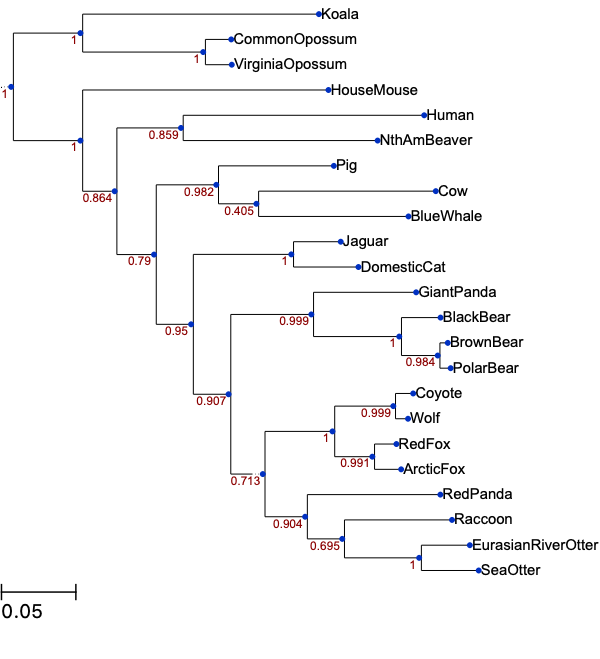

In [51]:
ts = TreeStyle()
ts.show_leaf_name = True
ts.show_branch_support = True
ts.branch_vertical_margin = 5 # Add 5 pixels of padding between branches
ts.scale =  1000 # 1000 pixels per branch-length unit
fstree.render(file_name='%%inline', w=600, tree_style=ts) # w is the width in pixels
# Change the '%%inline' to 'myfile.png' (or .pdf, .jpg, .tiff, .svg) to make an image file

By all means, do change those values above at will, comment some of those instructions out, and see what happens.

Note that we used `'%%inline'` as the "name" of the file. This tells Jupyter to put the image directly here in the notebook, but we can create files too.

### Exporting a tree image to a file
All we have to do to export the tree to an image instead of to the Jupyter screen is change the `'%%inline'` to a file name, whose extension (and type) can be `.pdf`, `.svg`, `.tiff`, `.jpg`, and more. ETE will judge from the extension which format it should produce.

Let's create a PDF:

In [52]:
fstree.render(file_name='Mammals_12S_rRNA.mafft.FastTree.pdf', w=800, tree_style=ts);

Go on take a look at the PDF. You may find that you need to change the style and width a bit, but this is a vector file anyway, so you can resize it at will in, say, Inkscape. And on that note:

#### Note on exporting to Inkscape
If your purpose is to do some aesthetic editing in Inkscape, I find that exporting to `PDF` and then importing that PDF into Inkscape works better than exporting to `SVG` (which is formally Inkscape's format).

### Colouring branches to match taxonomy
Recall that we have the taxonomic order of each mammal stored in the `.order` attribute of each leaf:

In [53]:
for leaf in fstree:
    print(leaf.name, ':', leaf.order, sep='\t')

Koala	:	Diprotodontia
CommonOpossum	:	Didelphimorphia
VirginiaOpossum	:	Didelphimorphia
HouseMouse	:	Rodentia
Human	:	Primates
NthAmBeaver	:	Rodentia
Pig	:	Artiodactyla
Cow	:	Artiodactyla
BlueWhale	:	Artiodactyla
Jaguar	:	Carnivora
DomesticCat	:	Carnivora
GiantPanda	:	Carnivora
BlackBear	:	Carnivora
BrownBear	:	Carnivora
PolarBear	:	Carnivora
Coyote	:	Carnivora
Wolf	:	Carnivora
RedFox	:	Carnivora
ArcticFox	:	Carnivora
RedPanda	:	Carnivora
Raccoon	:	Carnivora
EurasianRiverOtter	:	Carnivora
SeaOtter	:	Carnivora


Let's use this order to colour the branches of our tree. Here are my selected colours, which I took from a [list of named web colours](https://en.wikipedia.org/wiki/Web_colors#Extended_colors):

In [54]:
bg_colors = {
    'Artiodactyla'    : 'Moccasin',
    'Carnivora'       : '#FACEC9', # A hexadecimal red-green-blue triplet preceded by #
    'Didelphimorphia' : 'DarkTurquoise',   # Marsupials get similar colours
    'Diprotodontia'   : 'MediumTurquoise', # Marsupials get similar colours
    'Primates'        : 'Lavender',
    'Rodentia'        : 'Burlywood',
    }

Note that for the carnivores I actually entered a hexadecimal triplet. I just wanted to show you that you can if you wish.

#### A function to apply colour to the branches

In [55]:
def colour_tree(tree, leaf_bg_colors, taxgroup='order'):
    """
    Adds an ete3 NodeStyle color to leaves of a tree.
    INPUTS:
    -tree           : An ete3 tree whose leaf nodes will be coloured according to their taxonomic group.
    -leaf_bg_colors : A dictionary whose keys are taxonomic group names and values are desired colours.
    -taxgroup       : Desired taxonomic group to be used for colouring. This is the key in the colors dictionary.
    
    Note that the tree leaf nodes MUST have a taxgroup attribute that matches the keys
    in the leaf_bg_colors dictionary! The default is 'order', but it can be anything
    """
    node_styles = {}
    for leaf in tree:
        # Create a new style for this leaf:
        node_styles[leaf.name] = NodeStyle()
        # Assign it the color of this leaf's taxgroup
        node_styles[leaf.name]['bgcolor'] = leaf_bg_colors[leaf.__dict__[taxgroup]] # Ask me about this if you wish
        # Assign this NodeStyle to the leaf node:
        leaf.set_style(node_styles[leaf.name])

#### A style to draw the trees

In [56]:
ts = TreeStyle()
ts.show_leaf_name = True
ts.show_branch_support = True
ts.mode = 'c' # Make the tree circular
ts.scale = 350 # pixels per branch-length unit

This style can be reused to draw another tree (for example, the IQ-Tree one).

#### Draw the tree

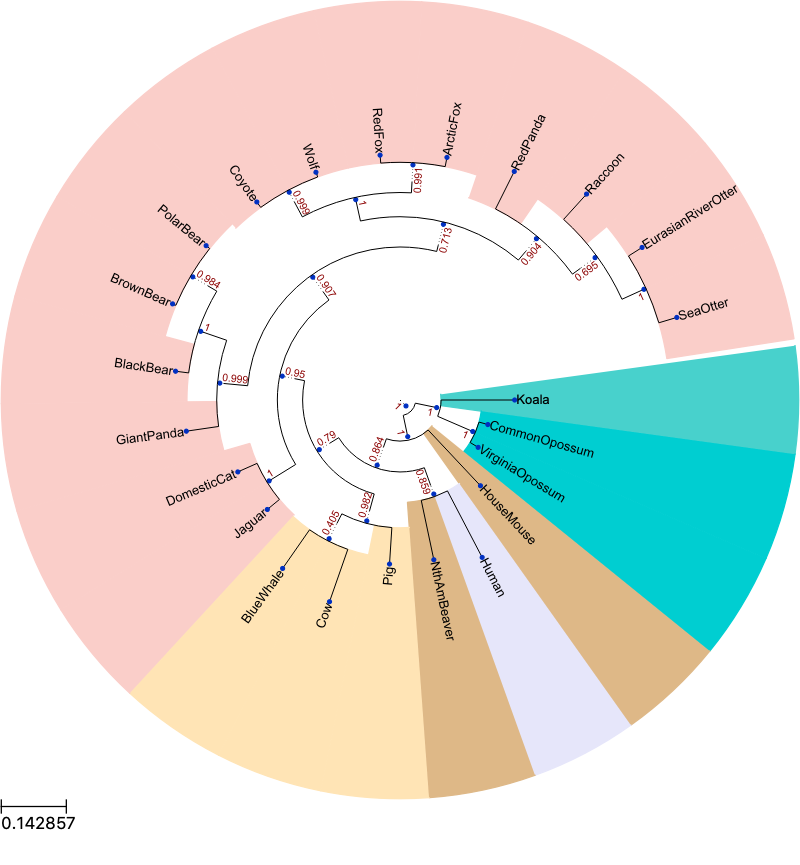

In [57]:
colour_tree(fstree, bg_colors)
fstree.render(file_name='%%inline', w=800, tree_style=ts) # w is the width in pixels

(I don't like that colour combination either. Feel free to change it if you're feeling artistic)

It's now very easy to see that the rodents are behaving strangely, that artiodactyls, carnivores and marsupials are all monophyletic, and that the marsupials are our chosen outgroup.

If we now wanted to render the IQ-Tree tree in the same way, we would only need to run the last two lines. However, this would fail because we never added the **order** to the leaves of that tree – we only did it to the FastTree tree (check out code cell #30 and #31 or thereabouts).

**Homework:** add the **order** to the branches of the IQ-Tree tree and and plot it as above:

In [58]:
# YOUR CODE TO ADD THE ORDER
# TO THE LEAVES GOES HERE

In [59]:
# YOUR CODE TO PLOT THE
# IQ-TREE TREE GOES HERE

Hint: each of those should only take two lines.

### Advanced ETE tree styling
There are a lot more options to get super fancy trees using `TreeStyle()`... and by "a lot" I mean _a lot_! Take a look at this gorgeous example that I copied almost verbatim from the `ETE` website:

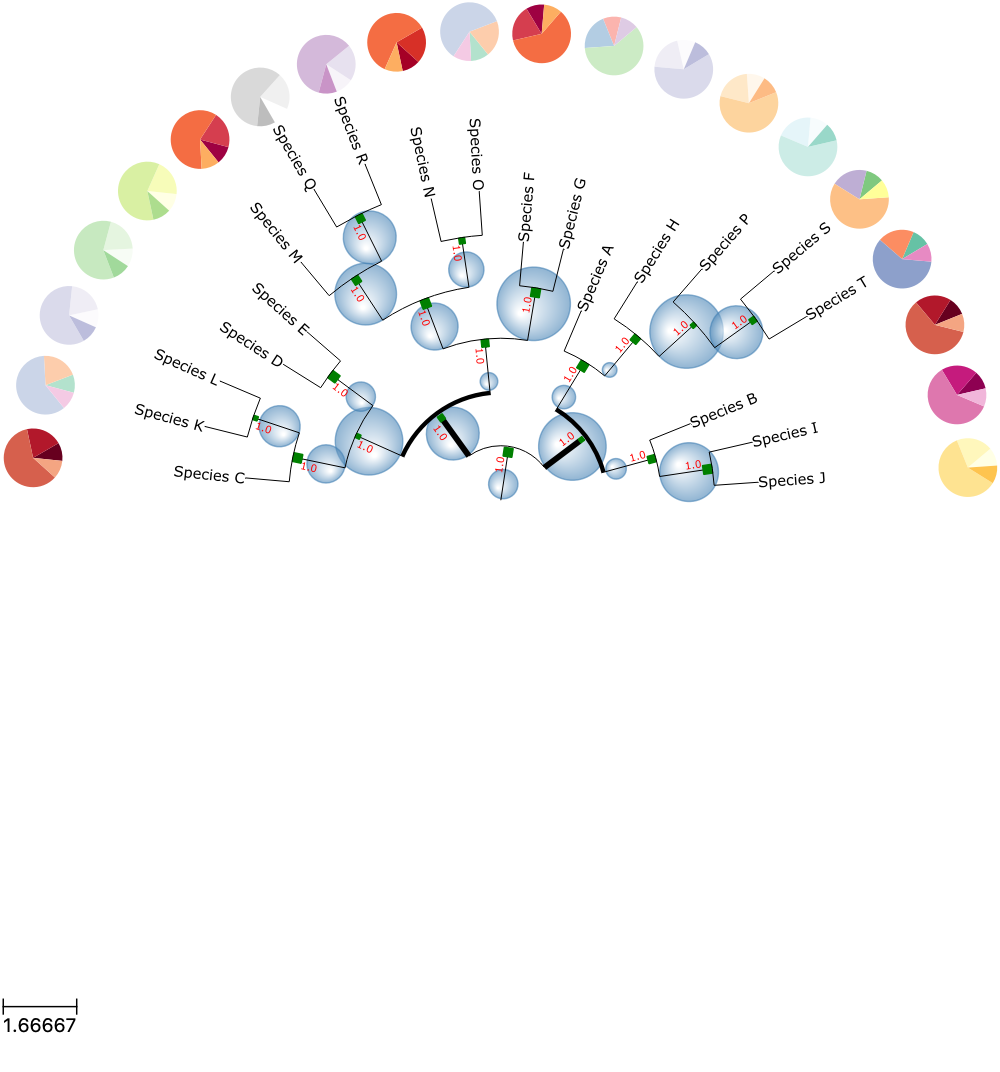

In [60]:
from ete3 import (Tree, TreeStyle, add_face_to_node, TextFace, AttrFace,
                  CircleFace, random_color, PieChartFace, COLOR_SCHEMES)
from random import randint, sample
schema_names = list(COLOR_SCHEMES.keys())

letters = [letter for letter in "ABCDEFGHIJKLMNOPQRSTUVWXYZ"]

def layout(node):
    if node.is_leaf():
        nameF = TextFace(f"Species {letters.pop(0)}", tight_text=False, fgcolor='black')
        add_face_to_node(nameF, node, column=0, position='branch-right')
        pieF = PieChartFace([10,20,60,10], colors=COLOR_SCHEMES[sample(schema_names, 1)[0]], width=40, height=40)
        add_face_to_node(pieF, node, column=0, position='aligned')
        node.img_style['size'] = 0
    else:
        node.img_style['size']    = randint(3,6)
        node.img_style['shape']   = 'square'
        node.img_style['fgcolor'] = 'green'
        bubble_face = CircleFace(randint(5,25), 'steelblue', 'sphere')
        bubble_face.opacity = 0.6
        add_face_to_node(bubble_face, node, column=0, position='float-behind')
        add_face_to_node(AttrFace('dist', fsize=7, fgcolor='red'), node, column=0, position='branch-top')
        
        if node.up and not node.up.up:
            node.img_style['vt_line_width'] = 3
            node.img_style['hz_line_width'] = 4

ts = TreeStyle()
ts.layout_fn = layout
ts.show_leaf_name = False
ts.mode = 'c'
ts.arc_start = 185
ts.arc_span = 180
ts.draw_guiding_lines = False
ts.scale = 30
t = Tree()
t.populate(20)
t.render(file_name='%%inline', w=1000, tree_style=ts)